In [10]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

# Load the dataset
data = pd.read_csv('/kaggle/input/annotated-bad-words/annotated_bad_words.csv')


In [11]:
# Preprocess the text data
def extract_labels(sentence):
    words = sentence.split()
    tokens = []
    labels = []
    
    for word in words:
        if "<bad_word>" in word:
            word = word.replace("<bad_word>", "").replace("</bad_word>", "")
            labels.append(1)  # Label '1' for bad word
        else:
            labels.append(0)  # Label '0' for normal word
        tokens.append(word)
    
    return " ".join(tokens), labels

In [12]:

# Apply label extraction
data['Processed Sentences'], data['Labels'] = zip(*data['Annotated Sentences'].apply(extract_labels))

# Split the data into training and test sets
sentences = data['Processed Sentences'].tolist()
labels = data['Labels'].tolist()
train_sentences, test_sentences, train_labels, test_labels = train_test_split(sentences, labels, test_size=0.2, random_state=42)


In [13]:

# Tokenize the sentences
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(train_sentences)
vocab_size = len(tokenizer.word_index) + 1
sequences = tokenizer.texts_to_sequences(sentences)


In [14]:

# Set max length based on longest sequence
max_length = max(len(seq) for seq in sequences)
print("Max length:", max_length)

train_sequences = tokenizer.texts_to_sequences(train_sentences)
test_sequences = tokenizer.texts_to_sequences(test_sentences)
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding='post', truncating='post')
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding='post', truncating='post')


Max length: 475


In [15]:
# Ensure labels are numpy arrays
train_labels = np.array(train_labels, dtype=object)  # Using dtype=object for lists of different lengths
test_labels = np.array(test_labels, dtype=object)


In [16]:
train_labels_padded = pad_sequences(train_labels, maxlen=max_length, padding='post', truncating='post')
test_labels_padded = pad_sequences(test_labels, maxlen=max_length, padding='post', truncating='post')

In [17]:
train_labels_padded = train_labels_padded[..., np.newaxis]
test_labels_padded = test_labels_padded[..., np.newaxis]   


In [18]:
embedding_index = {}
embedding_dim = 300  
with open(r"/kaggle/input/ccji300vec/cc.hi.300.vec", encoding="utf-8") as f:
    for line in f:
        values = line.strip().split()
        word = values[0]
        vector = np.asarray(values[1:], dtype="float32")
        embedding_index[word] = vector


In [19]:
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector


In [20]:

# Define character-level input
char_tokenizer = Tokenizer(char_level=True, oov_token="<OOV>")
char_tokenizer.fit_on_texts(sentences)
char_vocab_size = len(char_tokenizer.word_index) + 1
char_max_length = 15  # max characters per word (you can adjust as needed)


In [21]:
def char_level_tokenizer(sentences):
    char_sequences = []
    for sentence in sentences:
        # Tokenize and pad character sequences for each word
        char_sequence = [[char_tokenizer.word_index.get(char, 0) for char in word] for word in sentence.split()]
        # Pad each word's character sequence
        char_sequence = pad_sequences(char_sequence, maxlen=char_max_length, padding="post")
        char_sequences.append(char_sequence)
    
    # Pad the entire sequence of words to ensure uniformity
    return pad_sequences(char_sequences, maxlen=max_length, padding='post', dtype='object')


In [22]:
train_char_sequences = char_level_tokenizer(train_sentences)
test_char_sequences = char_level_tokenizer(test_sentences)


In [23]:
# Build the model
word_input = tf.keras.layers.Input(shape=(max_length,))
word_embedding = tf.keras.layers.Embedding(
    input_dim=vocab_size,
    output_dim=embedding_dim,
    weights=[embedding_matrix],
    trainable=False
)(word_input)

char_input = tf.keras.layers.Input(shape=(max_length, char_max_length))
char_embedding = tf.keras.layers.TimeDistributed(
    tf.keras.layers.Embedding(input_dim=char_vocab_size, output_dim=32, input_length=char_max_length)
)(char_input)

char_conv = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv1D(32, kernel_size=3, activation='relu'))(char_embedding)
char_pool = tf.keras.layers.TimeDistributed(tf.keras.layers.GlobalMaxPooling1D())(char_conv)

concatenated = tf.keras.layers.concatenate([word_embedding, char_pool])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [24]:
lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))(concatenated)
dense = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(32, activation='relu'))(lstm)
output = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1, activation='sigmoid'))(dense)


In [25]:
# Check the shapes and types of the padded arrays
print(f"Train sequences shape: {train_padded.shape}, Train labels shape: {train_labels_padded.shape}, Train labels type: {train_labels_padded.dtype}")
print(f"Test sequences shape: {test_padded.shape}, Test labels shape: {test_labels_padded.shape}, Test labels type: {test_labels_padded.dtype}")

Train sequences shape: (8099, 475), Train labels shape: (8099, 475, 1), Train labels type: int32
Test sequences shape: (2025, 475), Test labels shape: (2025, 475, 1), Test labels type: int32


In [26]:
train_padded = np.array(train_padded, dtype=np.int32)
test_padded = np.array(test_padded, dtype=np.int32)
train_char_sequences = np.array(train_char_sequences, dtype=np.int32)
test_char_sequences = np.array(test_char_sequences, dtype=np.int32)

# Print shapes and types for verification
print(f"Train padded shape: {train_padded.shape}, Train padded type: {train_padded.dtype}")
print(f"Test padded shape: {test_padded.shape}, Test padded type: {test_padded.dtype}")
print(f"Train char sequences shape: {train_char_sequences.shape}, Train char sequences type: {train_char_sequences.dtype}")
print(f"Test char sequences shape: {test_char_sequences.shape}, Test char sequences type: {test_char_sequences.dtype}")


Train padded shape: (8099, 475), Train padded type: int32
Test padded shape: (2025, 475), Test padded type: int32
Train char sequences shape: (8099, 475, 15), Train char sequences type: int32
Test char sequences shape: (2025, 475, 15), Test char sequences type: int32


In [27]:
# Define and compile the model
model = tf.keras.Model(inputs=[word_input, char_input], outputs=output)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = model.fit(
    [train_padded, train_char_sequences], train_labels_padded,
    epochs=5,
    validation_data=([test_padded, test_char_sequences], test_labels_padded)
)

# Evaluate the model
loss, accuracy = model.evaluate([test_padded, test_char_sequences], test_labels_padded)
print(f'Test Accuracy: {accuracy * 100:.2f}%')


Epoch 1/5
254/254 ━━━━━━━━━━━━━━━━━━━━ 332s 690ms/step - accuracy: 0.9972 - loss: 0.0373 - val_accuracy: 0.9994 - val_loss: 0.0020
Epoch 2/5
254/254 ━━━━━━━━━━━━━━━━━━━━ 148s 583ms/step - accuracy: 0.9994 - loss: 0.0018 - val_accuracy: 0.9996 - val_loss: 0.0013
Epoch 3/5
254/254 ━━━━━━━━━━━━━━━━━━━━ 148s 582ms/step - accuracy: 0.9997 - loss: 0.0011 - val_accuracy: 0.9997 - val_loss: 0.0010
Epoch 4/5
254/254 ━━━━━━━━━━━━━━━━━━━━ 149s 585ms/step - accuracy: 0.9997 - loss: 8.6113e-04 - val_accuracy: 0.9998 - val_loss: 7.9500e-04
Epoch 5/5
254/254 ━━━━━━━━━━━━━━━━━━━━ 148s 583ms/step - accuracy: 0.9998 - loss: 7.7106e-04 - val_accuracy: 0.9998 - val_loss: 7.2980e-04
64/64 ━━━━━━━━━━━━━━━━━━━━ 7s 106ms/step - accuracy: 0.9998 - loss: 6.6652e-04
Test Accuracy: 99.98%


In [29]:
# Evaluate the model
loss, accuracy = model.evaluate([test_padded, test_char_sequences], test_labels_padded)
print(f'Test Accuracy: {accuracy*100:.2f}%')

64/64 ━━━━━━━━━━━━━━━━━━━━ 7s 106ms/step - accuracy: 0.9998 - loss: 6.6652e-04
Test Accuracy: 99.98%


In [30]:
def preprocess_sentence(sentence):
    """
    Preprocesses a single sentence by tokenizing and padding for both word and character levels.
    """
    # Tokenize the sentence for words
    word_sequence = tokenizer.texts_to_sequences([sentence])
    padded_word_sequence = pad_sequences(word_sequence, maxlen=max_length, padding='post', truncating='post')
    
    # Tokenize and pad character sequences for each word
    char_sequence = [[char_tokenizer.word_index.get(char, 0) for char in word] for word in sentence.split()]
    char_sequence = pad_sequences(char_sequence, maxlen=char_max_length, padding="post")

    # Pad the entire sequence of words to ensure uniformity
    padded_char_sequence = pad_sequences([char_sequence], maxlen=max_length, padding='post', dtype='int32')

    return padded_word_sequence, padded_char_sequence

def predict_bad_words(sentence):
    """
    Predicts bad words in a new sentence.
    """
    # Preprocess the sentence
    padded_word_sequence, padded_char_sequence = preprocess_sentence(sentence)
    
    # Get predictions from the model
    predictions = model.predict([padded_word_sequence, padded_char_sequence])
    
    # Threshold to classify as bad word or not
    threshold = 0.5
    predicted_labels = (predictions > threshold).astype(int)[0]  # Flatten the predictions array
    
    # Print out each word with its prediction
    words = sentence.split()
    for i, word in enumerate(words[:max_length]):
        is_bad_word = "Bad Word" if predicted_labels[i] == 1 else "Normal Word"
        print(f"{word}: {is_bad_word}")

# Example sentence in Hindi containing some abusive words
new_sentence = "हम सब एक ही आदमी को वोट देंगे और अगर किसी ने वोट दिया तो उसकी गांड को"
# Predict on the new sentence
predict_bad_words(new_sentence)


1/1 ━━━━━━━━━━━━━━━━━━━━ 27s 27s/step
हम: Normal Word
सब: Normal Word
एक: Normal Word
ही: Normal Word
आदमी: Normal Word
को: Normal Word
वोट: Normal Word
देंगे: Normal Word
और: Normal Word
अगर: Normal Word
किसी: Normal Word
ने: Normal Word
वोट: Normal Word
दिया: Normal Word
तो: Normal Word
उसकी: Normal Word
गांड: Bad Word
को: Normal Word
लंबे: Normal Word
लौड़े: Bad Word
से: Normal Word
खेल: Normal Word
खिलाएंगे।: Normal Word
सब: Normal Word
बात: Normal Word
को: Normal Word
समझ: Normal Word
जाओ: Normal Word
वरना: Normal Word
तुम्हारी: Normal Word
ऐसी: Normal Word
गांड: Bad Word
मारी: Bad Word
जाएगी: Normal Word
कि: Normal Word
मंगल: Normal Word
के: Normal Word
लोग: Normal Word
भी: Normal Word
वाह: Normal Word
बोलेंगे: Normal Word
और: Normal Word
अगर: Normal Word
कोई: Normal Word
ज्यादा: Normal Word
बकचोदी: Bad Word
करेगा: Normal Word
तो: Normal Word
मैं: Normal Word
उसे: Normal Word
ये: Normal Word
कहना: Normal Word
चाहता: Normal Word
हूं: Normal Word
की: Normal Word
मैं: Normal Word
तु

In [31]:
# Save the model to a file
model.save('fast_text_bad_word_detection_model.h5')  # You can change the filename as needed

import pickle

# # Save the word tokenizer
with open('ft_word_tokenizer.pkl', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Save the character tokenizer
with open('ft_char_tokenizer.pkl', 'wb') as handle:
    pickle.dump(char_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

model.save("word2vec_bad_model.h5")

import json

hyperparams = {
    'max_length': max_length,
    'char_max_length': char_max_length,
}

with open('ft_hyperparameters.json', 'w') as f:
    json.dump(hyperparams, f)


In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from gensim.models import Word2Vec

# Load the dataset
data = pd.read_csv('/kaggle/input/annotated-bad-words/annotated_bad_words.csv')

# Preprocess the text data
def extract_labels(sentence):
    words = sentence.split()
    tokens = []
    labels = []
    
    for word in words:
        if "<bad_word>" in word:
            word = word.replace("<bad_word>", "").replace("</bad_word>", "")
            labels.append(1)  # Label '1' for bad word
        else:
            labels.append(0)  # Label '0' for normal word
        tokens.append(word)
    
    return " ".join(tokens), labels

# Apply label extraction
data['Processed Sentences'], data['Labels'] = zip(*data['Annotated Sentences'].apply(extract_labels))

# Split the data into training and test sets
sentences = data['Processed Sentences'].tolist()
labels = data['Labels'].tolist()
train_sentences, test_sentences, train_labels, test_labels = train_test_split(sentences, labels, test_size=0.2, random_state=42)

# Tokenize the sentences
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(train_sentences)
vocab_size = len(tokenizer.word_index) + 1
sequences = tokenizer.texts_to_sequences(sentences)

# Set max length based on longest sequence
max_length = max(len(seq) for seq in sequences)
train_sequences = tokenizer.texts_to_sequences(train_sentences)
test_sequences = tokenizer.texts_to_sequences(test_sentences)
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding='post', truncating='post')
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding='post', truncating='post')

# Ensure labels are numpy arrays and pad them to the same length
train_labels_padded = pad_sequences(train_labels, maxlen=max_length, padding='post', truncating='post')
test_labels_padded = pad_sequences(test_labels, maxlen=max_length, padding='post', truncating='post')

# Train a Word2Vec model on your corpus
embedding_dim = 100  # Adjust based on your Word2Vec model's vector size
word2vec_model = Word2Vec(sentences=[sentence.split() for sentence in sentences], vector_size=embedding_dim, window=5, min_count=1, workers=4)

# Prepare the embedding matrix
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    if word in word2vec_model.wv:
        embedding_matrix[i] = word2vec_model.wv[word]

# Define character-level input
char_tokenizer = Tokenizer(char_level=True, oov_token="<OOV>")
char_tokenizer.fit_on_texts(sentences)
char_vocab_size = len(char_tokenizer.word_index) + 1
char_max_length = 15  # max characters per word

def char_level_tokenizer(sentences):
    char_sequences = []
    for sentence in sentences:
        char_sequence = [[char_tokenizer.word_index.get(char, 0) for char in word] for word in sentence.split()]
        char_sequence = pad_sequences(char_sequence, maxlen=char_max_length, padding="post")
        char_sequences.append(char_sequence)
    return pad_sequences(char_sequences, maxlen=max_length, padding='post', dtype='object')

train_char_sequences = char_level_tokenizer(train_sentences)
test_char_sequences = char_level_tokenizer(test_sentences)

# Build the model
word_input = tf.keras.layers.Input(shape=(max_length,))
word_embedding = tf.keras.layers.Embedding(
    input_dim=vocab_size,
    output_dim=embedding_dim,
    weights=[embedding_matrix],
    trainable=False
)(word_input)

char_input = tf.keras.layers.Input(shape=(max_length, char_max_length))
char_embedding = tf.keras.layers.TimeDistributed(
    tf.keras.layers.Embedding(input_dim=char_vocab_size, output_dim=32, input_length=char_max_length)
)(char_input)
char_conv = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv1D(32, kernel_size=3, activation='relu'))(char_embedding)
char_pool = tf.keras.layers.TimeDistributed(tf.keras.layers.GlobalMaxPooling1D())(char_conv)

# Concatenate word and character embeddings
concatenated = tf.keras.layers.concatenate([word_embedding, char_pool])

# LSTM layer
lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))(concatenated)
dense = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(32, activation='relu'))(lstm)
output = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1, activation='sigmoid'))(dense)

# Convert the data to int32 for training
train_padded = np.array(train_padded, dtype=np.int32)
test_padded = np.array(test_padded, dtype=np.int32)
train_char_sequences = np.array(train_char_sequences, dtype=np.int32)
test_char_sequences = np.array(test_char_sequences, dtype=np.int32)

# Define and compile the model
model = tf.keras.Model(inputs=[word_input, char_input], outputs=output)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = model.fit(
    [train_padded, train_char_sequences], train_labels_padded,
    epochs=5,
    validation_data=([test_padded, test_char_sequences], test_labels_padded)
)

# Evaluate the model
loss, accuracy = model.evaluate([test_padded, test_char_sequences], test_labels_padded)
print(f'Test Accuracy: {accuracy * 100:.2f}%')


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5
254/254 ━━━━━━━━━━━━━━━━━━━━ 332s 679ms/step - accuracy: 0.9748 - loss: 0.0623 - val_accuracy: 0.9990 - val_loss: 0.0028
Epoch 2/5
254/254 ━━━━━━━━━━━━━━━━━━━━ 145s 571ms/step - accuracy: 0.9991 - loss: 0.0025 - val_accuracy: 0.9994 - val_loss: 0.0018
Epoch 3/5
254/254 ━━━━━━━━━━━━━━━━━━━━ 145s 570ms/step - accuracy: 0.9995 - loss: 0.0017 - val_accuracy: 0.9996 - val_loss: 0.0013
Epoch 4/5
254/254 ━━━━━━━━━━━━━━━━━━━━ 145s 571ms/step - accuracy: 0.9996 - loss: 0.0012 - val_accuracy: 0.9997 - val_loss: 0.0011
Epoch 5/5
254/254 ━━━━━━━━━━━━━━━━━━━━ 145s 570ms/step - accuracy: 0.9997 - loss: 9.7655e-04 - val_accuracy: 0.9997 - val_loss: 9.5799e-04
64/64 ━━━━━━━━━━━━━━━━━━━━ 7s 107ms/step - accuracy: 0.9997 - loss: 8.9757e-04
Test Accuracy: 99.97%


In [8]:
max_length

475

In [9]:
import pickle

# # Save the word tokenizer
with open('word_tokenizer.pkl', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Save the character tokenizer
with open('char_tokenizer.pkl', 'wb') as handle:
    pickle.dump(char_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

model.save("word2vec_bad_model.h5")

import json

hyperparams = {
    'max_length': max_length,
    'char_max_length': char_max_length,
}

with open('hyperparameters.json', 'w') as f:
    json.dump(hyperparams, f)


In [3]:
def preprocess_sentence(sentence):
    """
    Preprocesses a single sentence by tokenizing and padding for both word and character levels.
    """
    # Tokenize the sentence for words
    word_sequence = tokenizer.texts_to_sequences([sentence])
    padded_word_sequence = pad_sequences(word_sequence, maxlen=max_length, padding='post', truncating='post')
    
    # Tokenize and pad character sequences for each word
    char_sequence = [[char_tokenizer.word_index.get(char, 0) for char in word] for word in sentence.split()]
    char_sequence = pad_sequences(char_sequence, maxlen=char_max_length, padding="post")
    
    # Pad the entire sequence of words to ensure uniformity
    padded_char_sequence = pad_sequences([char_sequence], maxlen=max_length, padding='post', dtype='int32')

    return padded_word_sequence, padded_char_sequence

def predict_bad_words(sentence):
    """
    Predicts bad words in a new sentence using the trained model.
    """
    # Preprocess the sentence
    padded_word_sequence, padded_char_sequence = preprocess_sentence(sentence)
    
    # Get predictions from the model
    predictions = model.predict([padded_word_sequence, padded_char_sequence])
    
    # Threshold to classify as bad word or not
    threshold = 0.5
    predicted_labels = (predictions > threshold).astype(int)[0]  # Flatten the predictions array
    
    # Print out each word with its prediction
    words = sentence.split()
    for i, word in enumerate(words[:max_length]):
        is_bad_word = "Bad Word" if predicted_labels[i] == 1 else "Normal Word"
        print(f"{word}: {is_bad_word}")

# Example sentence in Hindi containing some abusive words
new_sentence = "तू हमेशा दूसरों को चुतिये और गांडू बोलता है, खुद हर बात में फुद्दी की बातें करता है, मादरचोद"
# Predict on the new sentence
predict_bad_words(new_sentence)


1/1 ━━━━━━━━━━━━━━━━━━━━ 27s 27s/step
तू: Normal Word
हमेशा: Normal Word
दूसरों: Normal Word
को: Normal Word
चुतिये: Normal Word
और: Normal Word
गांडू: Bad Word
बोलता: Normal Word
है,: Normal Word
खुद: Normal Word
हर: Normal Word
बात: Normal Word
में: Normal Word
फुद्दी: Normal Word
की: Normal Word
बातें: Normal Word
करता: Normal Word
है,: Normal Word
मादरचोद: Bad Word


In [20]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

# Load the dataset
data = pd.read_csv('/kaggle/input/annotated-bad-words/annotated_bad_words.csv')

# Preprocess the text data
def extract_labels(sentence):
    words = sentence.split()
    tokens = []
    labels = []
    
    for word in words:
        if "<bad_word>" in word:
            word = word.replace("<bad_word>", "").replace("</bad_word>", "")
            labels.append(1)  # Label '1' for bad word
        else:
            labels.append(0)  # Label '0' for normal word
        tokens.append(word)
    
    return " ".join(tokens), labels

# Apply label extraction
data['Processed Sentences'], data['Labels'] = zip(*data['Annotated Sentences'].apply(extract_labels))

# Split the data into training and test sets
sentences = data['Processed Sentences'].tolist()
labels = data['Labels'].tolist()
train_sentences, test_sentences, train_labels, test_labels = train_test_split(sentences, labels, test_size=0.2, random_state=42)

# Tokenize the sentences
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(train_sentences)
vocab_size = len(tokenizer.word_index) + 1

# Set max length based on longest sequence
max_length = max(len(sentence.split()) for sentence in sentences)
train_sequences = tokenizer.texts_to_sequences(train_sentences)
test_sequences = tokenizer.texts_to_sequences(test_sentences)
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding='post', truncating='post')
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding='post', truncating='post')

# Ensure labels are numpy arrays and pad them to the same length
train_labels_padded = pad_sequences(train_labels, maxlen=max_length, padding='post', truncating='post')
test_labels_padded = pad_sequences(test_labels, maxlen=max_length, padding='post', truncating='post')

# Load GloVe embeddings
def load_glove_embeddings(glove_file):
    embeddings_index = {}
    with open(glove_file, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    return embeddings_index

# Specify your GloVe file path
glove_file = '/kaggle/input/glove-global-vectors-for-word-representation/glove.6B.100d.txt'  # Update this path
embeddings_index = load_glove_embeddings(glove_file)

# Prepare the embedding matrix
embedding_dim = 100  # Adjust based on your GloVe model's vector size
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    if word in embeddings_index:
        embedding_matrix[i] = embeddings_index[word]

# Define character-level input
char_tokenizer = Tokenizer(char_level=True, oov_token="<OOV>")
char_tokenizer.fit_on_texts(sentences)
char_vocab_size = len(char_tokenizer.word_index) + 1
char_max_length = 15  # max characters per word

def char_level_tokenizer(sentences):
    char_sequences = []
    for sentence in sentences:
        char_sequence = [[char_tokenizer.word_index.get(char, 0) for char in word] for word in sentence.split()]
        char_sequence = pad_sequences(char_sequence, maxlen=char_max_length, padding="post")
        char_sequences.append(char_sequence)
    return pad_sequences(char_sequences, maxlen=max_length, padding='post', dtype='object')

train_char_sequences = char_level_tokenizer(train_sentences)
test_char_sequences = char_level_tokenizer(test_sentences)

# Build the model
word_input = tf.keras.layers.Input(shape=(max_length,))
word_embedding = tf.keras.layers.Embedding(
    input_dim=vocab_size,
    output_dim=embedding_dim,
    weights=[embedding_matrix],
    trainable=False
)(word_input)

char_input = tf.keras.layers.Input(shape=(max_length, char_max_length))
char_embedding = tf.keras.layers.TimeDistributed(
    tf.keras.layers.Embedding(input_dim=char_vocab_size, output_dim=32, input_length=char_max_length)
)(char_input)
char_conv = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv1D(32, kernel_size=3, activation='relu'))(char_embedding)
char_pool = tf.keras.layers.TimeDistributed(tf.keras.layers.GlobalMaxPooling1D())(char_conv)

# Concatenate word and character embeddings
concatenated = tf.keras.layers.concatenate([word_embedding, char_pool])

# LSTM layer
lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))(concatenated)
dense = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(32, activation='relu'))(lstm)
output = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1, activation='sigmoid'))(dense)

# Convert the data to int32 for training
train_padded = np.array(train_padded, dtype=np.int32)
test_padded = np.array(test_padded, dtype=np.int32)
train_char_sequences = np.array(train_char_sequences, dtype=np.int32)
test_char_sequences = np.array(test_char_sequences, dtype=np.int32)

# Define and compile the model
model = tf.keras.Model(inputs=[word_input, char_input], outputs=output)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = model.fit(
    [train_padded, train_char_sequences], train_labels_padded,
    epochs=5,
    validation_data=([test_padded, test_char_sequences], test_labels_padded)
)

# Evaluate the model
loss, accuracy = model.evaluate([test_padded, test_char_sequences], test_labels_padded)
print(f'Test Accuracy: {accuracy * 100:.2f}%')


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5
254/254 ━━━━━━━━━━━━━━━━━━━━ 341s 707ms/step - accuracy: 0.9955 - loss: 0.0537 - val_accuracy: 0.9986 - val_loss: 0.0036
Epoch 2/5
254/254 ━━━━━━━━━━━━━━━━━━━━ 151s 594ms/step - accuracy: 0.9988 - loss: 0.0032 - val_accuracy: 0.9994 - val_loss: 0.0021
Epoch 3/5
254/254 ━━━━━━━━━━━━━━━━━━━━ 151s 594ms/step - accuracy: 0.9994 - loss: 0.0020 - val_accuracy: 0.9996 - val_loss: 0.0015
Epoch 4/5
254/254 ━━━━━━━━━━━━━━━━━━━━ 151s 593ms/step - accuracy: 0.9995 - loss: 0.0016 - val_accuracy: 0.9996 - val_loss: 0.0012
Epoch 5/5
254/254 ━━━━━━━━━━━━━━━━━━━━ 152s 599ms/step - accuracy: 0.9997 - loss: 0.0012 - val_accuracy: 0.9997 - val_loss: 9.8129e-04
64/64 ━━━━━━━━━━━━━━━━━━━━ 8s 117ms/step - accuracy: 0.9997 - loss: 9.4676e-04
Test Accuracy: 99.97%


64/64 ━━━━━━━━━━━━━━━━━━━━ 74s 588ms/step
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    959085
           1       0.94      0.96      0.95      2790

    accuracy                           1.00    961875
   macro avg       0.97      0.98      0.98    961875
weighted avg       1.00      1.00      1.00    961875

Confusion Matrix:
[[958926    159]
 [   106   2684]]


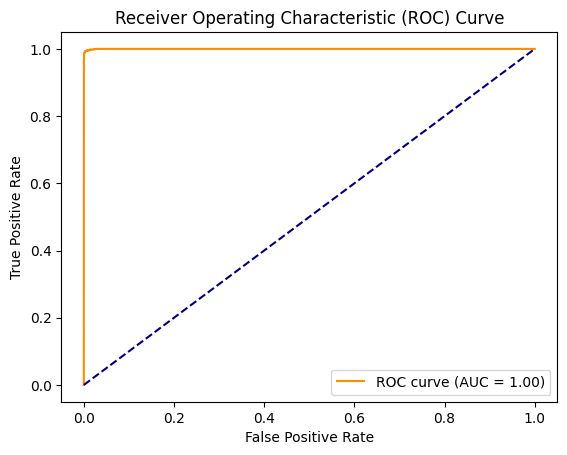

In [21]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# 1. Predict probabilities on the test data
y_pred_proba = model.predict([test_padded, test_char_sequences])

# 2. Convert probabilities to binary predictions using a threshold (e.g., 0.5)
y_pred = (y_pred_proba > 0.5).astype(int)

# 3. Flatten the predictions and true labels for comparison at the token level
y_true = test_labels_padded.flatten()
y_pred_flat = y_pred.flatten()
y_pred_proba_flat = y_pred_proba.flatten()

# 4. Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred_flat))

# 5. Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred_flat))

# 6. AUC-ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_pred_proba_flat)
roc_auc = roc_auc_score(y_true, y_pred_proba_flat)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


In [17]:
def preprocess_sentence(sentence):
    """
    Preprocesses a single sentence by tokenizing and padding for both word and character levels.
    """
    # Tokenize the sentence for words
    word_sequence = tokenizer.texts_to_sequences([sentence])
    padded_word_sequence = pad_sequences(word_sequence, maxlen=max_length, padding='post', truncating='post')
    
    # Tokenize and pad character sequences for each word
    char_sequence = [[char_tokenizer.word_index.get(char, 0) for char in word] for word in sentence.split()]
    char_sequence = pad_sequences(char_sequence, maxlen=char_max_length, padding="post")
    
    # Pad the entire sequence of words to ensure uniformity
    padded_char_sequence = pad_sequences([char_sequence], maxlen=max_length, padding='post', dtype='int32')

    return padded_word_sequence, padded_char_sequence

def predict_bad_words(sentence):
    """
    Predicts bad words in a new sentence using the trained model.
    """
    # Preprocess the sentence
    padded_word_sequence, padded_char_sequence = preprocess_sentence(sentence)
    
    # Get predictions from the model
    predictions = model.predict([padded_word_sequence, padded_char_sequence])
    
    # Threshold to classify as bad word or not
    threshold = 0.5
    predicted_labels = (predictions > threshold).astype(int)[0]  # Flatten the predictions array
    
    # Print out each word with its prediction
    words = sentence.split()
    
    # Adjust this for padded sequences if necessary
    for i, word in enumerate(words[:max_length]):
        # Check if the index is within the predicted labels
        if i < len(predicted_labels):
            is_bad_word = "Bad Word" if predicted_labels[i] == 1 else "Normal Word"
            print(f"{word}: {is_bad_word}")
        else:
            print(f"{word}: Out of range")  # In case there are more words than labels

# Example sentence in Hindi containing some abusive words
new_sentence = "तू खुद को क्या समझता है, चूतिया साला? हर बार बकवास करता है और दूसरों को परेशान करता है। कमीने, तमीज से पेश आ।"
# Predict on the new sentence
predict_bad_words(new_sentence)


1/1 ━━━━━━━━━━━━━━━━━━━━ 35s 35s/step
तू: Normal Word
खुद: Normal Word
को: Normal Word
क्या: Normal Word
समझता: Normal Word
है,: Normal Word
चूतिया: Bad Word
साला?: Bad Word
हर: Normal Word
बार: Normal Word
बकवास: Normal Word
करता: Normal Word
है: Normal Word
और: Normal Word
दूसरों: Normal Word
को: Normal Word
परेशान: Normal Word
करता: Normal Word
है।: Normal Word
कमीने,: Bad Word
तमीज: Normal Word
से: Normal Word
पेश: Normal Word
आ।: Normal Word


64/64 ━━━━━━━━━━━━━━━━━━━━ 36s 112ms/step
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    959085
           1       0.95      0.92      0.94      2790

    accuracy                           1.00    961875
   macro avg       0.97      0.96      0.97    961875
weighted avg       1.00      1.00      1.00    961875

Confusion Matrix:
[[958944    141]
 [   214   2576]]


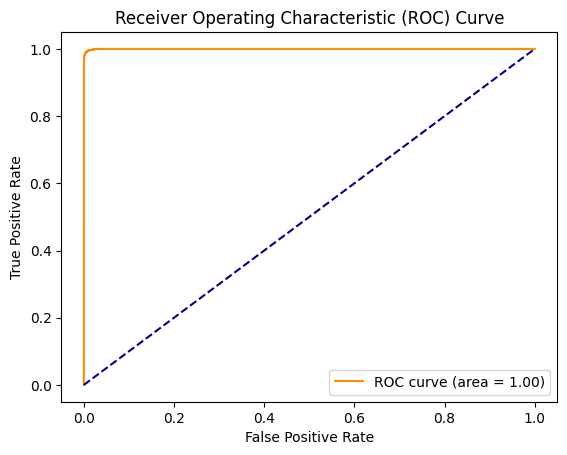

In [19]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# 1. Predict probabilities on the test data
y_pred_proba = model.predict([test_padded, test_char_sequences])

# 2. Convert probabilities to binary predictions using a threshold (e.g., 0.5)
y_pred = (y_pred_proba > 0.5).astype(int)

# 3. Flatten the predictions and true labels for comparison at the token level
y_true = test_labels_padded.flatten()
y_pred_flat = y_pred.flatten()

# 4. Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred_flat))

# 5. Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred_flat))

# 6. AUC-ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_pred_proba.flatten())
roc_auc = roc_auc_score(y_true, y_pred_proba.flatten())

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


In [18]:
model.save("glove_bad_word_detection_model.h5")

# MODEL CHANGE

In [ ]:
print("Train padded shape:", train_padded.shape)  # Should be (num_samples, max_length)
print("Train char sequences shape:", train_char_sequences.shape)  # Should be (num_samples, max_length, char_max_length)
print("Train labels shape:", train_labels_padded.shape)  # Should be (num_samples, max_length, 1)
